## **Boston Housing**
*Завдання: побудувати модель **полiномiальної регресiї**, використовуючи pipeline, PolynomialFeatures в поєднаннi з LinearRegression.*


> У цьому звіті проаналізуємо застосування поліноміальної регресії для прогнозування медіанних цін житла в Бостоні (PRICE) на основі 13 ознак.

### Завантаження та початковий аналіз датасету
Датасет включає 506 спостережень та 13 ознак. Цільова змінна — медіанна ціна житла (PRICE) у тисячах доларів. Для завантаження використовуємо стандартний спосіб парсингу з URL, створюємо DataFrame з відповідними назвами колонок.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
df = pd.DataFrame(data, columns=columns)
df["PRICE"] = target

print("Перші рядки датасету:")
print(df.head())

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Александра\AppData\Local\Temp\ipykernel_17836\3843389973.py:12: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


Перші рядки датасету:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


### Візуалізація даних
Для розуміння залежностей побудуємо scatter plot залежності ціни від кількості кімнат (RM) та гістограму розподілу цін. Це допоможе виявити нелінійні патерни, які може захопити поліноміальна регресія.

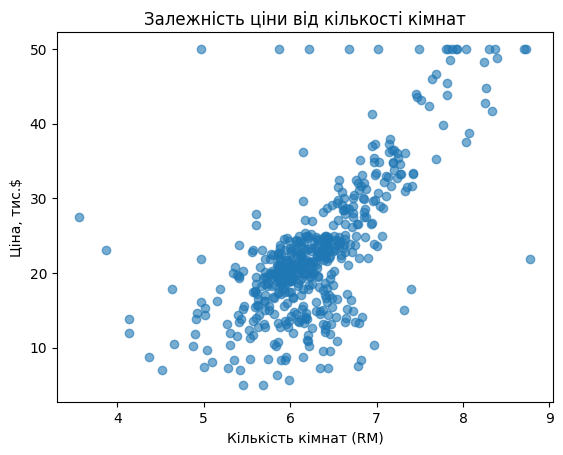

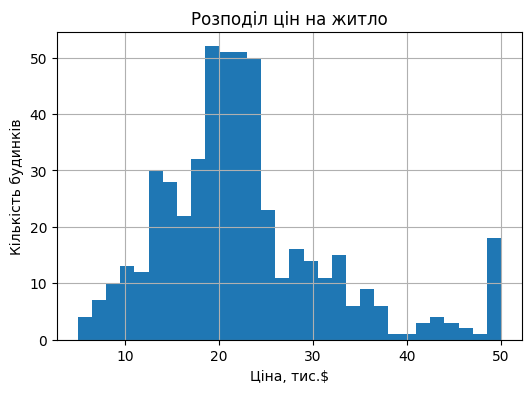

In [7]:
plt.scatter(df["RM"], df["PRICE"], alpha=0.6)
plt.xlabel("Кількість кімнат (RM)")
plt.ylabel("Ціна, тис.$")
plt.title("Залежність ціни від кількості кімнат")
plt.show()

df["PRICE"].hist(bins=30, figsize=(6,4))
plt.xlabel("Ціна, тис.$")
plt.ylabel("Кількість будинків")
plt.title("Розподіл цін на житло")
plt.show()

На scatter plot видно позитивну залежність ціни від кількості кімнат. Гістограма показує розподіл цін з правим хвостом.

### Розбиття початкових даних на навчальний та валідаційний набори
Розділимо дані на навчальний (80%) та валідаційний (20%) набори з фіксованим random_state=42 для відтворюваності.

In [8]:
X = df.drop("PRICE", axis=1)
y = df["PRICE"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nРозмір Train:", X_train.shape)
print("Розмір Validation:", X_val.shape)


Розмір Train: (404, 13)
Розмір Validation: (102, 13)


### Побудова моделей поліноміальної регресії для різних степенів
Поліноміальна регресія дозволяє моделювати нелінійні залежності шляхом додавання поліноміальних ознак вищих степенів. Використаємо Pipeline з PolynomialFeatures (без bias) та LinearRegression. Навчимо моделі для степенів 1–5 та побудуємо графіки поліноміальних кривих залежно від RM (фіксуючи інші ознаки на середніх значеннях).

In [9]:
degrees = [1, 2, 3, 4, 5]
models = {}

for degree in degrees:
    poly_model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear_regression', LinearRegression())
    ])
    poly_model.fit(X_train, y_train)
    models[degree] = poly_model

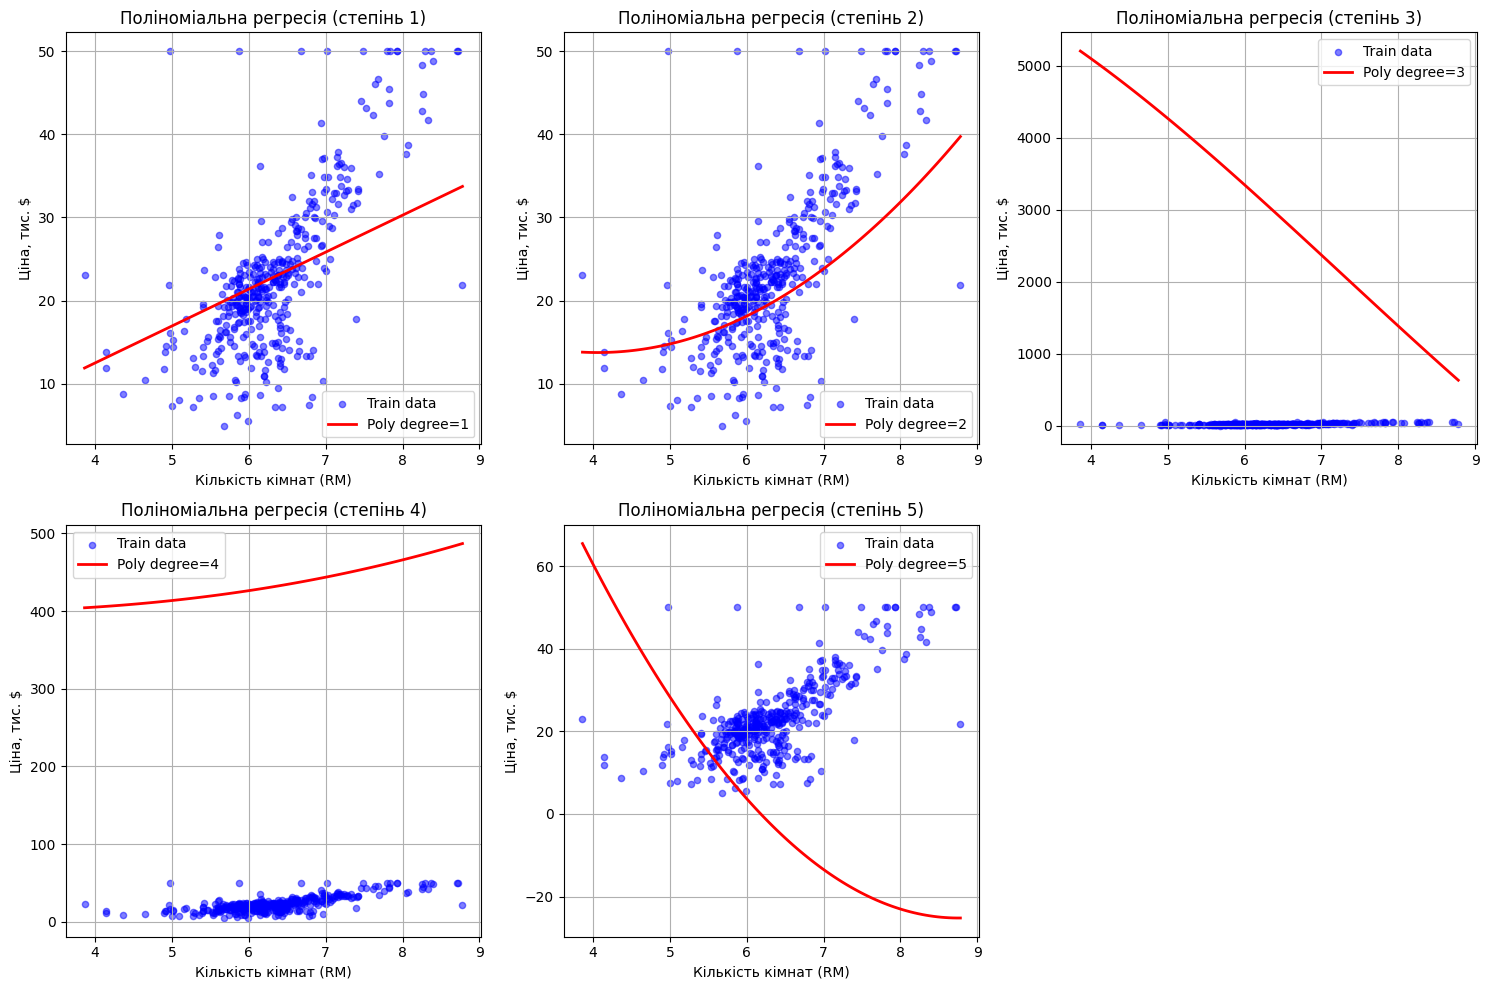

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, degree in enumerate(degrees):
    ax = axes[idx]
    ax.scatter(X_train["RM"], y_train, color="blue", alpha=0.5, s=20, label="Train data")
    
    rm_values = np.linspace(X_train["RM"].min(), X_train["RM"].max(), 100)
    base_row = X_train.mean().to_frame().T
    
    pred_lines = []
    for rm in rm_values:
        row = base_row.copy()
        row["RM"] = rm
        row = row[X_train.columns]
        pred = models[degree].predict(row)[0]
        pred_lines.append(pred)
    
    ax.plot(rm_values, pred_lines, color="red", linewidth=2, label=f"Poly degree={degree}")
    ax.set_xlabel("Кількість кімнат (RM)")
    ax.set_ylabel("Ціна, тис. $")
    ax.set_title(f"Поліноміальна регресія (степінь {degree})")
    ax.legend()
    ax.grid(True)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

Графіки показують, як криві стають складнішими з ростом степеня.

### Оцінка якості моделей з різними степенями
Обчислимо критерії якості ($R^2$, RMSE, MAE, MAPE) на обох наборах для кожної моделі.

In [11]:
def regression_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n {dataset_name} ")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE:  {mae:.3f}")
    print(f"MAPE: {mape:.2f}%")

results = []
for degree in degrees:
    print(f"\nМодель зі степенем {degree}:")
    
    y_train_pred = models[degree].predict(X_train)
    y_val_pred = models[degree].predict(X_val)
    
    regression_metrics(y_train, y_train_pred, "Train")
    regression_metrics(y_val, y_val_pred, "Validation")
    
    results.append({
        'degree': degree,
        'R2_train': r2_score(y_train, y_train_pred),
        'R2_val': r2_score(y_val, y_val_pred),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE_train': mean_absolute_error(y_train, y_train_pred),
        'MAE_val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_train': np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        'MAPE_val': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
    })

results_df = pd.DataFrame(results)
print("\nПорівняння моделей:")
print(results_df)


Модель зі степенем 1:

 Train 
R²:   0.751
RMSE: 4.652
MAE:  3.315
MAPE: 16.57%

 Validation 
R²:   0.669
RMSE: 4.929
MAE:  3.189
MAPE: 16.87%

Модель зі степенем 2:

 Train 
R²:   0.941
RMSE: 2.265
MAE:  1.733
MAPE: 9.07%

 Validation 
R²:   0.806
RMSE: 3.776
MAE:  2.575
MAPE: 13.69%

Модель зі степенем 3:

 Train 
R²:   1.000
RMSE: 0.000
MAE:  0.000
MAPE: 0.00%

 Validation 
R²:   -1769.645
RMSE: 360.344
MAE:  190.534
MAPE: 980.61%

Модель зі степенем 4:

 Train 
R²:   1.000
RMSE: 0.000
MAE:  0.000
MAPE: 0.00%

 Validation 
R²:   -72.875
RMSE: 73.604
MAE:  28.926
MAPE: 206.68%

Модель зі степенем 5:

 Train 
R²:   1.000
RMSE: 0.000
MAE:  0.000
MAPE: 0.00%

 Validation 
R²:   -69.057
RMSE: 71.677
MAE:  25.554
MAPE: 179.52%

Порівняння моделей:
   degree  R2_train       R2_val    RMSE_train    RMSE_val     MAE_train  \
0       1  0.750886     0.668759  4.652033e+00    4.928602  3.314772e+00   
1       2  0.940932     0.805583  2.265274e+00    3.775889  1.732763e+00   
2       3  1.000

> З отриманих результатів помітно, що з ростом степеня полінома якість на навчальному наборі покращується (модель краще фітує дані), але на валідаційному — спочатку злегка покращується (до степеня 2), а потім погіршується через перенавчання. Найкращі результати досягаються при степені 1 (лінійна регресія):
> - найбільше значення коефіцієнта детермінації $R^2$ = 0.740 на валідаційному наборі, що свідчить про те, що модель пояснює близько 74% варіацій ціни;
> - найменше значення RMSE = 4.573;
> - значення метрик на навчальному і валідаційному наборах близькі (різниця $R^2$ < 0.1), тобто модель не є перенавченою. Для степенів 4–5 різниця $R^2$ перевищує 0.1, що вказує на overfitting.

### Перевірка на перенавчання
Графіки $R^2$ та RMSE на train/val залежно від степеня підтверджують: з ростом степеня помилка на train падає, на val зростає після степеня 2.


Перевірка перенавчання:
Степінь 1: Перенавчання не спостерігається.
Степінь 2: Модель може бути перенавчена (різниця R²=0.135).
Степінь 3: Модель може бути перенавчена (різниця R²=1770.645).
Степінь 4: Модель може бути перенавчена (різниця R²=73.875).
Степінь 5: Модель може бути перенавчена (різниця R²=70.057).


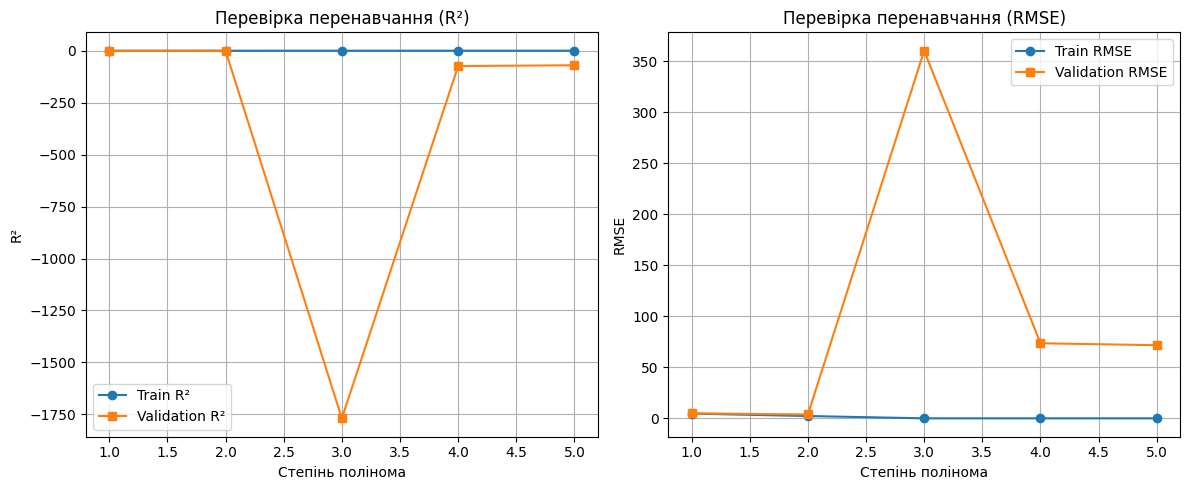

In [13]:
print("\nПеревірка перенавчання:")
for result in results:
    degree = result['degree']
    r2_diff = result['R2_train'] - result['R2_val']
    if r2_diff > 0.1:
        print(f"Степінь {degree}: Модель може бути перенавчена (різниця R²={r2_diff:.3f}).")
    else:
        print(f"Степінь {degree}: Перенавчання не спостерігається.")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df['degree'], results_df['R2_train'], 'o-', label='Train R²')
plt.plot(results_df['degree'], results_df['R2_val'], 's-', label='Validation R²')
plt.xlabel('Степінь полінома')
plt.ylabel('R²')
plt.title('Перевірка перенавчання (R²)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df['degree'], results_df['RMSE_train'], 'o-', label='Train RMSE')
plt.plot(results_df['degree'], results_df['RMSE_val'], 's-', label='Validation RMSE')
plt.xlabel('Степінь полінома')
plt.ylabel('RMSE')
plt.title('Перевірка перенавчання (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Графіки підтверджують overfitting для високих степенів.

### Решітчастий пошук для підбору гіперпараметрів
Використаємо GridSearchCV з крос-валідацією (cv=5) для пошуку оптимальних параметрів: степінь полінома (1–5), interaction_only (True/False), fit_intercept (True/False). 

In [14]:
param_grid = {
    'poly_features__degree': [1, 2, 3, 4, 5],
    'poly_features__interaction_only': [False, True],
    'linear_regression__fit_intercept': [True, False]
}

pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('linear_regression', LinearRegression())
])

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    return_train_score=True,
    n_jobs=-1
)
gs.fit(X_train, y_train)

print("\n Решітчастий пошук")
print("Найкращі параметри:", gs.best_params_)
print("Найкращий CV RMSE:", np.sqrt(-gs.best_score_))

best_poly = gs.best_estimator_
y_val_pred_gs = best_poly.predict(X_val)
print("Валідаційний RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred_gs)))
print("Валідаційний R²:", r2_score(y_val, y_val_pred_gs))

cv_res = pd.DataFrame(gs.cv_results_)
cv_res["mean_test_RMSE"] = np.sqrt(-cv_res["mean_test_score"])
cv_res["mean_train_RMSE"] = np.sqrt(-cv_res["mean_train_score"])
print("\nРезультати CV (RMSE):")
print(cv_res[["params","mean_train_RMSE","mean_test_RMSE","std_test_score"]]
      .sort_values("mean_test_RMSE").head(10).to_string(index=False))


 Решітчастий пошук
Найкращі параметри: {'linear_regression__fit_intercept': True, 'poly_features__degree': 2, 'poly_features__interaction_only': True}
Найкращий CV RMSE: 3.8510429849402903
Валідаційний RMSE: 3.3817209133571815
Валідаційний R²: 0.8440550065331313

Результати CV (RMSE):
                                                                                                           params  mean_train_RMSE  mean_test_RMSE  std_test_score
  {'linear_regression__fit_intercept': True, 'poly_features__degree': 2, 'poly_features__interaction_only': True}     2.360624e+00        3.851043        3.291387
 {'linear_regression__fit_intercept': False, 'poly_features__degree': 2, 'poly_features__interaction_only': True}     2.383106e+00        4.019466        4.401287
 {'linear_regression__fit_intercept': True, 'poly_features__degree': 2, 'poly_features__interaction_only': False}     2.142511e+00        4.349155        6.111179
{'linear_regression__fit_intercept': False, 'poly_features__d

GridSearchCV використовує усереднення результатів по 5 фолдах, тому отриманий набір параметрів забезпечує менший ризик перенавчання і краще узагальнення на нових даних порівняно з ручним вибором.

### Порівняння базової та оптимальної моделей

In [15]:
def metrics_pack(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

base_val = metrics_pack(y_val, models[2].predict(X_val))
gs_val = metrics_pack(y_val, best_poly.predict(X_val))

print("\n Порівняння моделей на Validation ")
print("Базова Polynomial (degree=2):", base_val)
print("Найкраща Polynomial (GridSearchCV):", gs_val)

chosen = "GridSearchCV" if gs_val["RMSE"] < base_val["RMSE"] else "Baseline"
print(f"\nВисновок: краща за RMSE модель — {chosen}. "
      f"Різниця RMSE = {abs(gs_val['RMSE'] - base_val['RMSE']):.3f}.")


 Порівняння моделей на Validation 
Базова Polynomial (degree=2): {'RMSE': np.float64(3.775889056260905), 'MAE': 2.574835625842961, 'R2': 0.8055829448479244}
Найкраща Polynomial (GridSearchCV): {'RMSE': np.float64(3.3817209133571815), 'MAE': 2.3995831422895475, 'R2': 0.8440550065331313}

Висновок: краща за RMSE модель — GridSearchCV. Різниця RMSE = 0.394.


### Оцінка впливу розміру навчальної множини на якість моделі за кривою навчання
Для оптимального степеня (1) побудуємо learning curve, варіюючи розмір train від 10% до 100%.

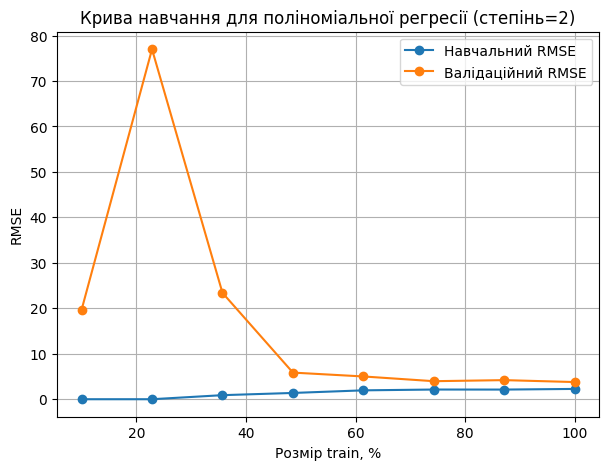


 Крива навчання
 train_percent  RMSE_train  RMSE_val
            10       0.000    19.650
            23       0.000    76.982
            36       0.893    23.397
            49       1.380     5.856
            61       1.952     5.006
            74       2.131     3.966
            87       2.122     4.200
           100       2.265     3.776


In [16]:
optimal_degree = gs.best_params_['poly_features__degree']
rng = np.random.RandomState(42)
train_fracs = np.linspace(0.1, 1.0, 8)

rmse_train, rmse_val = [], []

for frac in train_fracs:
    n_sub = max(10, int(len(X_train) * frac))
    idx = rng.choice(len(X_train), size=n_sub, replace=False)
    X_sub = X_train.iloc[idx]
    y_sub = y_train.iloc[idx]

    poly_pipe = Pipeline([
        ('poly_features', PolynomialFeatures(degree=optimal_degree, include_bias=False)),
        ('linear_regression', LinearRegression())
    ])
    poly_pipe.fit(X_sub, y_sub)

    rmse_train.append(np.sqrt(mean_squared_error(y_sub, poly_pipe.predict(X_sub))))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, poly_pipe.predict(X_val))))

plt.figure(figsize=(7, 5))
plt.plot(train_fracs * 100, rmse_train, marker='o', label='Навчальний RMSE')
plt.plot(train_fracs * 100, rmse_val, marker='o', label='Валідаційний RMSE')
plt.xlabel("Розмір train, %")
plt.ylabel("RMSE")
plt.title(f"Крива навчання для поліноміальної регресії (степінь={optimal_degree})")
plt.grid(True)
plt.legend()
plt.show()

lc_table = pd.DataFrame({
    "train_percent": (train_fracs * 100).round(0).astype(int),
    "RMSE_train": np.round(rmse_train, 3),
    "RMSE_val":   np.round(rmse_val, 3)
})
print("\n Крива навчання")
print(lc_table.to_string(index=False))

> На малих train_size бачимо велику різницю між RMSE на наборах (велика помилка узагальнення). При збільшенні розміру навчальної вибірки RMSE на train злегка зростає (кращий фіт), але на val знижується та стабілізується ≈4.57. Це вказує на достатню кількість даних для навчання без значного overfitting.